# Notebook to show how we computed PPH and SigSVR in Australia with the LSR data there and to show how we selected our cases and the areas for them  
## Note that the reports in Australia are much more sparse than the reports in the US so we had to adjust some parameters

In [10]:
# install metpy version 1.6.3 for this notebook only
!uv pip install metpy==1.6.3

Using Python 3.13.2 environment at: ExtremeWeatherBench/.venv
Audited 1 package in 5ms


In [11]:
# all the imports you should need for this notebook

import xarray as xr
import metpy
import numpy as np
import pandas as pd
# Add colorbar with same height as plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import requests
from typing import Optional, Union, Literal
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import requests
import matplotlib.colors as mcolors

# added by amy
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from matplotlib.lines import Line2D

# make the basepath - change this to your local path
from pathlib import Path
basepath = Path.home() / 'ExtremeWeatherBench' / ''
basepath = str(basepath) + '/'


# Functions to read in and plot the data in Australia

In [20]:
# This is modified from the original code for CONUS to work with Australian LSR data
def extract_lsr_data_australia(date: pd.Timestamp) -> pd.DataFrame:
    """Pull the latest LSR data for a given date. We pull all reorts within 1 day. If date is none, we return all reports
    
    Args:
        date: A pandas Timestamp object.
    Returns:
        df: A pandas DataFrame containing the LSR data with columns lat, lon, report_type, time, and scale.
    """

    #aus_file = "gs://extremeweatherbench/datasets/AustralianLSRData_2020-2024.csv"
    aus_file = '/home/amy/AustralianLSRData_2020-2024.csv'

    # Read the CSV files with all columns to identify report types
    try:
        #df = pd.read_csv(aus_file, delimiter=',', engine='python', storage_options=dict(token="anon"), parse_dates=['Date/Time UTC'], date_format='%Y-%m-%d %H:%M:%S')
        df = pd.read_csv(aus_file, delimiter=',', engine='python', parse_dates=['Date/Time UTC'], date_format='%Y-%m-%d %H:%M:%S')
    except Exception as e:
        print(f'Error pulling hail data for {date}: {e}')
        return pd.DataFrame()
    
    # if date is none, presumably we want all reports
    if (date == None):
        return df

    # Filter the DataFrame for the specified date range
       # Filter the DataFrame for the specified date range
    spc_date = pd.Timestamp(date.year, date.month, date.day, 12, 00)  # Normalize to noon
    start_date = spc_date    
    end_date = spc_date + pd.Timedelta(days=1.0)
    df = df[(df['Date/Time UTC'] >= start_date) & (df['Date/Time UTC'] < end_date)]
    if len(df) == 0:
        print(f'No LSR data found for {date}')
        return pd.DataFrame()
    return df


In [13]:
# imported from figure 1 notebook and adjusted to plot reports
def plot_local_cases(left_lon, right_lon, bot_lat, top_lat, df, filename, plot_title, pph=None, sigsvr=None):
    """Plot the specified cases on a map of Australia.
    Args:
        left_lon: The left longitude of the bounding box.
        right_lon: The right longitude of the bounding box.
        bot_lat: The bottom latitude of the bounding box.
        top_lat: The top latitude of the bounding box.
        df: A pandas DataFrame containing the LSR data with columns 'Longitude', 'Latitude', and 'report_type'.
        filename: The name of the file to save the plot.
        plot_title: The title of the plot.
        pph: A 2D array of probabilities for plotting (optional).
        sigsvr: A 2D array of SIGSVR values for plotting (optional).
    Returns:
        None: The function saves the plot to the specified filename.
    """
    fig = plt.figure(figsize=(15, 10))
    #ax = plt.axes(projection=ccrs.LambertConformal())
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')
    #ax.add_feature(cfeature.OCEAN, zorder=10)
    #utils.remove_ocean_gridpoints(sigsvr)
    my_box = [left_lon, right_lon, bot_lat, top_lat]
    ax.set_extent(my_box, crs=ccrs.PlateCarree())

    # Add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()

    if (pph is not None):
        # Plot the data using contourf
        levels = [0.01, .05,.15,.30,.45,.60,.75]  # 10 levels between 0 and 1

        # Create a custom colormap that sets alpha=0 for values below 0.05
        cmap = plt.cm.viridis
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Create the colormap with alpha=0 for values below 0.05
        # Create a mask for values below 0.05
        mask = np.ma.masked_less(pph, 0.01)
        cmap_with_alpha = plt.cm.viridis.copy()
        cmap_with_alpha.set_bad('none', alpha=0)  # Set masked values to transparent

        contour = ax.contour(pph.longitude, pph.latitude, mask, 
                            levels=levels, transform=ccrs.PlateCarree(),
                            cmap=cmap_with_alpha, extend='both')

        # Add colorbar
        #cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
        #cbar.set_label('Probability')

    if (sigsvr is not None):
        masked_sigsvr = sigsvr.where(sigsvr >= 500)
        print(masked_sigsvr.max())
        im = masked_sigsvr.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds',
                        add_colorbar=False, vmin=0)
        cbar = fig.colorbar(im, label="Craven SigSvr (m³/s³)")
        cbar.set_label("Craven SigSvr (m³/s³)", size=14)
        cbar.ax.tick_params(labelsize=12)

    # Make sure reports are visible by increasing size and using a distinctive color
    # Convert string coordinates to float before plotting
    colors = {'tor': 'red','wind': 'blue', 'hail': 'black'}
    markers= {'tor': 'o', 'wind': 's', 'hail': '^'}  

    # Define zorder values to control plotting order (higher values appear on top)
    zorders = {'tor': 12, 'wind': 11, 'hail': 10}
    
    # Sort the dataframe by report type to ensure tornadoes are plotted last (on top)
    # Create a custom sort order where 'tor' comes last
    sort_order = {'hail': 0, 'wind': 1, 'tor': 2}
    sorted_df = df.copy()
    sorted_df['sort_key'] = sorted_df['report_type'].map(sort_order)
    
    # Group by report type and plot each group with its own color
    for report_type, group in sorted_df.sort_values('sort_key').groupby('report_type'):
        ax.scatter(group['Longitude'].astype(float), group['Latitude'].astype(float), 
                  color=colors.get(report_type, 'gray'), s=20, marker=markers.get(report_type), alpha=0.9,
                  transform=ccrs.PlateCarree(), label=f'{report_type.capitalize()} Reports', 
                  zorder=zorders.get(report_type, 10))

    # Count the number of reports for each type
    counts = df['report_type'].value_counts().to_dict()
    print(counts)

    # Create custom legend handles
    legend_elements = [
        Line2D([0], [0], marker=markers.get(label), color=colors[label], label=f'{label} (n={count})', markerfacecolor=colors[label], markersize=10)
        for label, count in counts.items()
    ]
    
     # Create a larger legend by specifying a larger font size in the prop dictionary
    ax.legend(handles=legend_elements, loc='lower left', framealpha=1, frameon=True, borderpad=0.5, handletextpad=0.8, handlelength=2.5)
    ax.set_title("")
    ax.set_title(plot_title, loc='left', fontsize=20)

    if (filename is not None):
        plt.savefig(filename, transparent=True)

{'tor': 77, 'hail': 74}


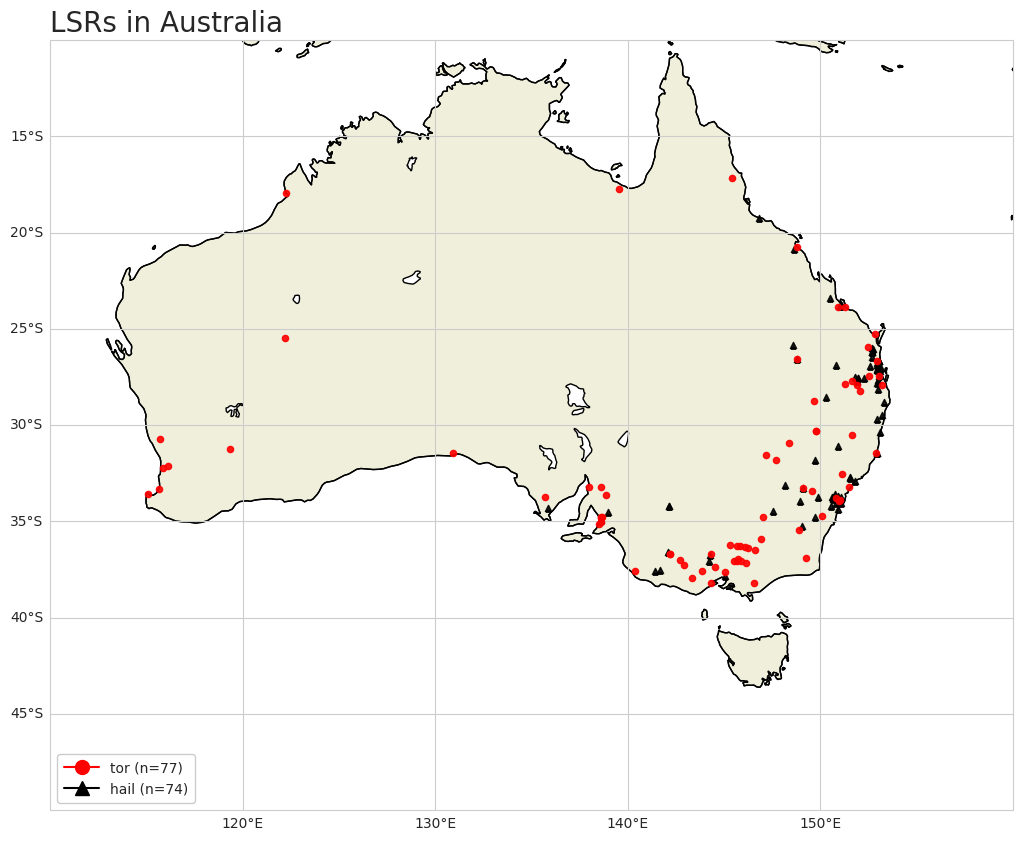

In [14]:
# quick test of all points in Australia
bot_lat = -50
top_lat = -10
left_lon = 110
right_lon = 160
filename = 'docs/notebooks/figs/Australia_LSR.png'
plot_title = 'LSRs in Australia'

aus_data = extract_lsr_data_australia(date=None)  # Get all reports

# set filename to the file if you want to actually save it
plot_local_cases(left_lon, right_lon, bot_lat, top_lat, aus_data, filename=basepath + filename, plot_title=plot_title)
    

In [16]:
def practically_perfect_hindcast_aus(
    date: pd.Timestamp,
    resolution: float = 0.25,
    report_type: Union[Literal["all"], list[Literal["tor", "hail", "wind"]]] = "all",
    sigma: float = 1.5,
    return_reports: bool = False,
    output_resolution: Optional[float] = None,
    report_constants = {'hail': 15, 'tor': 5}
) -> Union[xr.DataArray, tuple[xr.DataArray, pd.DataFrame]]:
    """Compute the Practically Perfect Hindcast (PPH) using storm report data using latitude/longitude grid spacing
    instead of the NCEP 212 Eta Lambert Conformal projection; based on the method described in Hitchens et al 2013,
    https://doi.org/10.1175/WAF-D-12-00113.1

    Args:
        date: A pandas Timestamp object.
        resolution: The resolution of the grid to use. Default is 0.25 degrees.
        report_type: The type of report to use. Default is all. Currently only supports all.
        sigma: The sigma (standard deviation) of the gaussian filter to use. Default is 1.5.
        return_reports: Whether to return the reports used to compute the PPH. Default is False.
        output_resolution: The resolution of the output grid. Default is None (keep the same resolution as the input grid).
        report_constants: A dictionary mapping report types to their respective values for the PPH grid. Default is {'hail': 15, 'tor': 5}.
    Returns:
        pph: An xarray DataArray containing the PPH around the storm report data.
    """

    df = extract_lsr_data_australia(date)
    if report_type == "all":
        pass
    else:
        df = df[df['report_type'].isin(report_type)]

    # Create a grid covering Australia
    lat_min, lat_max = -50, -10.0   
    lon_min, lon_max = 110, 180  

    # Create the grid coordinates
    grid_lats = np.arange(lat_min, lat_max + resolution, resolution)
    grid_lons = np.arange(lon_min, lon_max + resolution, resolution)

    # Initialize an empty grid
    grid = np.zeros((len(grid_lats), len(grid_lons)))

    # extract reports for TOR and HAIL separately to handle the underreporting
    for report_type in report_constants.keys():
        # Filter the dataframe for the current report type
        df2 = df[df['report_type'] == report_type]

        # Extract latitude and longitude from the dataframe
        lats = df2["Latitude"].astype(float)
        lons = df2["Longitude"].astype(float)

        # Mark grid cells that contain reports
        for lat, lon in zip(lats, lons):
            # Find the nearest grid indices
            lat_idx = np.abs(grid_lats - lat).argmin()
            lon_idx = np.abs(grid_lons - lon).argmin()
            grid[lat_idx, lon_idx] = report_constants[report_type]  # Set a value to indicate a report is present

    # Create the xarray DataArray
    pph = xr.DataArray(
        grid,
        dims=["latitude", "longitude"],
        coords={"latitude": grid_lats, "longitude": grid_lons},
        name="practically_perfect",
    )

    # Apply bilinear interpolation to smooth the field
    # First, create a gaussian kernel for smoothing
    smoothed_grid = gaussian_filter(grid, sigma=sigma)

    # Replace the data in the DataArray
    pph.data = smoothed_grid
    if output_resolution is not None:
        pph = pph.interp(latitude=np.arange(lat_min, lat_max + output_resolution, output_resolution),
                        longitude=np.arange(lon_min, lon_max + output_resolution, output_resolution),method='linear')
    if return_reports:
        return (pph, df)
    return pph

In [ ]:
# plot a specific test case with PPH to verify that it is working well with the chosen weights
date = pd.Timestamp(2021,10,28,00,00)
pph_aus = practically_perfect_hindcast_aus(date, sigma=5, report_constants={'tor': 10, 'hail': 50})

start_date = date - pd.Timedelta(days=0.5)    
end_date = date + pd.Timedelta(days=0.5)
daily_data = aus_data[(aus_data['Date/Time UTC'] >= start_date) & (aus_data['Date/Time UTC'] < end_date)]
    
# plot PPH and the cases
plot_local_cases(left_lon, right_lon, bot_lat, top_lat, daily_data, None, plot_title, pph=pph_aus)

#print(pph_aus)
#pph_aus.plot()

In [22]:
# look through every date in the australia data print the case count for all non-zero dates
aus_data = extract_lsr_data_australia(date=None)  # Get all reports

# loop through all dates from 2020-2024
for date in pd.date_range('2020-01-01', '2024-12-31'):
     # Filter the DataFrame for the specified date range
    # Filter the DataFrame for the specified date range
    spc_date = pd.Timestamp(date.year, date.month, date.day, 12, 00)  # Normalize to noon
    start_date = spc_date    
    end_date = spc_date + pd.Timedelta(days=1.0)
    daily_data = aus_data[(aus_data['Date/Time UTC'] >= start_date) & (aus_data['Date/Time UTC'] < end_date)]
    
    if len(daily_data) >= 2:
        # Count the number of reports for each type
        counts = daily_data['report_type'].value_counts().to_dict()
        print(f"{date.strftime('%Y-%m-%d')}: {len(daily_data)} reports - {counts}")

        filename = f"docs/notebooks/figs/Australia_LSR_{date.strftime('%Y-%m-%d')}.png"
        plot_title = f"LSRs in Australia for {date.strftime('%Y-%m-%d')}"

        # compute PPH on this date
        pph_aus = practically_perfect_hindcast_aus(date, sigma=5, report_constants={'tor': 10, 'hail': 10})

        # plot PPH and the cases
        #plot_local_cases(left_lon, right_lon, bot_lat, top_lat, daily_data, filename=None, plot_title=plot_title, pph=pph_aus)
        #plt.close()

        

2020-01-19: 2 reports - {'hail': 2}
2020-04-02: 2 reports - {'tor': 2}
2020-05-30: 3 reports - {'tor': 3}
2020-09-24: 2 reports - {'tor': 2}
2020-10-30: 2 reports - {'hail': 2}
2020-12-04: 2 reports - {'tor': 2}
2021-09-29: 6 reports - {'hail': 4, 'tor': 2}
2021-10-13: 6 reports - {'hail': 4, 'tor': 2}
2021-10-17: 5 reports - {'hail': 4, 'tor': 1}
2021-10-18: 2 reports - {'hail': 1, 'tor': 1}
2021-10-27: 4 reports - {'hail': 2, 'tor': 2}
2021-12-02: 2 reports - {'hail': 2}
2021-12-08: 2 reports - {'hail': 2}
2022-01-14: 2 reports - {'hail': 1, 'tor': 1}
2022-03-03: 2 reports - {'hail': 2}
2022-12-07: 2 reports - {'hail': 2}
2023-02-13: 3 reports - {'hail': 3}
2023-12-11: 2 reports - {'tor': 2}
2023-12-24: 2 reports - {'hail': 1, 'tor': 1}
2023-12-25: 2 reports - {'hail': 2}
2024-08-24: 12 reports - {'tor': 11, 'hail': 1}
2024-10-08: 3 reports - {'hail': 3}
2024-10-16: 2 reports - {'hail': 2}
2024-10-31: 2 reports - {'hail': 1, 'tor': 1}
2024-11-12: 3 reports - {'hail': 3}


# Load ERA5

In [ ]:
# load ERA-5
era5 = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),)

# Load in metadata for Australia plots

In [ ]:
#metadata
bot_lat = -50
top_lat = -10
left_lon = 110
right_lon = 160

date = pd.Timestamp(2021,10,28,00,00)

# Create a DataArray with latitude and longitude coordinates
# Latitude range: -50 to -10 with 0.25 degree resolution
# Longitude range: 110 to 180 with 0.25 degree resolution

# Calculate the number of points for each dimension
lat_points = int(((-10) - (-50)) / 0.25) + 1  # From -50 to -10
lon_points = int((180 - 110) / 0.25) + 1      # From 110 to 180

# Create coordinate arrays
lats = np.linspace(-50, -10, lat_points)
lons = np.linspace(110, 180, lon_points)

# Create an empty data array filled with zeros
data = np.zeros((len(lats), len(lons)))

# Create the xarray DataArray
new_australia_dataarray = xr.DataArray(
    data=data,
    dims=["latitude", "longitude"],
    coords={
        "latitude": lats,
        "longitude": lons
    },
    name="example_data"
)

# Fast CAPE 

In [ ]:
# fast cape calculation
# first show it for one date
date = pd.Timestamp(2021,10,28,00,00)
era5_test = era5.sel(time=[date],latitude=new_australia_dataarray.latitude, longitude=new_australia_dataarray.longitude, method='nearest')
era5_test = era5_test.rename({'10m_u_component_of_wind': 'surface_eastward_wind',
                            '10m_v_component_of_wind': 'surface_northward_wind',
                            'u_component_of_wind': 'eastward_wind',
                            'v_component_of_wind': 'northward_wind',
                            'temperature': 'air_temperature',
                            })
era5_test = era5_test[['eastward_wind','northward_wind','air_temperature','surface_eastward_wind','surface_northward_wind','specific_humidity']]
era5_test = era5_test.compute()
era5_test = era5_test.reindex(level = era5_test.level[::-1])
era5_test['dewpoint_temperature'] = metpy.calc.dewpoint_from_specific_humidity(era5_test['level'] * metpy.units.units.hPa, era5_test['specific_humidity'] * metpy.units.units.dimensionless)

era5_test = era5_test.rename({'air_temperature':'temperature','dewpoint_temperature':'dewpoint'})
era5_test['pressure'] = xr.broadcast(era5_test['level'], era5_test['temperature'])[0]
era5_test['dewpoint'] = era5_test['dewpoint'].metpy.dequantify() + 273.15
era5_test = era5_test.transpose('time','latitude','longitude','level').sel(level=era5_test.level>=20)


In [ ]:
# import the fast cape calculation from the derived notebook
import docs.notebooks.derived as derived

In [ ]:
# all temperatures in kelvin, pressure in hPa
bb_cape, bb_cin = derived.mixed_layer_cape_cin(era5_test, pressure_var='pressure', temperature_var='temperature', temperature_dewpoint_var='dewpoint')

# Create a new variable for Craven-Brooks significant severe parameter
# Using bb_cape as the CAPE component
# Create as DataArray with proper dimensions
era5_craven_test = xr.DataArray(
    bb_cape,
    dims=['latitude', 'longitude','time'],
    coords={
        'time': era5_test.time,
        'latitude': era5_test.latitude,
        'longitude': era5_test.longitude
    }
)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Plot the data with a red colormap
cape_plot = era5_craven_test.plot(ax=ax, transform=ccrs.PlateCarree(), 
                                  cmap='Reds',add_colorbar=False,)

# Set extent to Australia region
ax.set_extent([left_lon, right_lon, bot_lat, top_lat], crs=ccrs.PlateCarree())
ax.set_title('')
# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
cbar = fig.colorbar(cape_plot, cax=cax, label="CAPE (J/kg)")
cbar.set_label("CAPE (J/kg)", size=14)
cbar.ax.tick_params(labelsize=12)
ax.set_title('CAPE Values over Australia', loc='left', fontsize=20)
plt.tight_layout()

# PPH Aus and Sig Severe Overlay:

In [ ]:
#era5_craven_test.plot()
#print(era5_craven_test)
date = pd.Timestamp(2021,10,28,00,00)

pph_aus = practically_perfect_hindcast_aus(date, sigma=5, report_constants={'tor': 10, 'hail': 50})

start_date = date - pd.Timedelta(days=0.5)    
end_date = date + pd.Timedelta(days=0.5)
daily_data = aus_data[(aus_data['Date/Time UTC'] >= start_date) & (aus_data['Date/Time UTC'] < end_date)]

bb_sigsvr = derived.craven_brooks_sig_svr(era5_test, pressure_var='pressure', temperature_var='temperature', temperature_dewpoint_var='dewpoint')

plot_local_cases(left_lon, right_lon, bot_lat, top_lat, daily_data, filename, plot_title, pph=pph_aus, sigsvr=bb_sigsvr)


In [ ]:
# look through every date in the australia data print the case count for all non-zero dates
aus_data = extract_lsr_data_australia(date=None)  # Get all reports

# loop through all dates from 2020-2024
for date in pd.date_range('2020-01-01', '2024-12-31'):
     # Filter the DataFrame for the specified date range
    start_date = date - pd.Timedelta(days=0.5)    
    end_date = date + pd.Timedelta(days=0.5)
    daily_data = aus_data[(aus_data['Date/Time UTC'] >= start_date) & (aus_data['Date/Time UTC'] < end_date)]
    
    if len(daily_data) >= 2:
        # Count the number of reports for each type
        counts = daily_data['report_type'].value_counts().to_dict()
        print(f"{date.strftime('%Y-%m-%d')}: {len(daily_data)} reports - {counts}")

        filename = f"docs/notebooks/figs/Australia_LSR_{date.strftime('%Y-%m-%d')}.png"
        plot_title = f"LSRs, PPH and SIGSVR in Australia for {date.strftime('%Y-%m-%d')}"

        # compute PPH on this date
        pph_aus = practically_perfect_hindcast_aus(date, sigma=5, report_constants={'tor': 10, 'hail': 50})

        # compute SIGSVR on this date
        # first subset the ERA5 data for the date
        era5_sub = era5.sel(time=[date],latitude=new_australia_dataarray.latitude, longitude=new_australia_dataarray.longitude, method='nearest')
        era5_sub = era5_sub.rename({'10m_u_component_of_wind': 'surface_eastward_wind',
                                    '10m_v_component_of_wind': 'surface_northward_wind',
                                    'u_component_of_wind': 'eastward_wind',
                                    'v_component_of_wind': 'northward_wind',
                                    'temperature': 'air_temperature',
                                    })
        era5_sub = era5_sub[['eastward_wind','northward_wind','air_temperature','surface_eastward_wind','surface_northward_wind','specific_humidity']]
        era5_sub = era5_sub.compute()
        era5_sub = era5_sub.reindex(level = era5_sub.level[::-1])
        era5_sub['dewpoint_temperature'] = metpy.calc.dewpoint_from_specific_humidity(era5_sub['level'] * metpy.units.units.hPa, era5_sub['specific_humidity'] * metpy.units.units.dimensionless)

        era5_sub = era5_sub.rename({'air_temperature':'temperature','dewpoint_temperature':'dewpoint'})
        era5_sub['pressure'] = xr.broadcast(era5_sub['level'], era5_sub['temperature'])[0]
        era5_sub['dewpoint'] = era5_sub['dewpoint'].metpy.dequantify() + 273.15
        era5_sub = era5_sub.transpose('time','latitude','longitude','level').sel(level=era5_sub.level>=20)

        # now compute the Craven-Brooks significant severe parameter
        bb_sigsvr = derived.craven_brooks_sig_svr(era5_sub, pressure_var='pressure', temperature_var='temperature', temperature_dewpoint_var='dewpoint')


        # plot PPH and the cases
        plot_local_cases(left_lon, right_lon, bot_lat, top_lat, daily_data, filename, plot_title, pph=pph_aus, sigsvr=bb_sigsvr)
        #plt.close()